<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/Lab3_Error_control_and_adaptive_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil
import numpy as np 


dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

dolfin version: 2018.1.0


output: 0.04468 est: 0.04327 err: 0.09713 cells: 98
output: 0.08817 est: 0.07273 err: 0.05364 cells: 142
output: 0.07914 est: 0.05156 err: 0.06267 cells: 201
output: 0.10368 est: 0.03999 err: 0.03813 cells: 307
output: 0.11171 est: 0.02852 err: 0.03010 cells: 479
output: 0.11499 est: 0.02050 err: 0.02682 cells: 751
output: 0.11738 est: 0.01472 err: 0.02443 cells: 1184
output: 0.12002 est: 0.01313 err: 0.02179 cells: 1840
output: 0.12110 est: 0.01118 err: 0.02071 cells: 2959
output: 0.12367 est: 0.00949 err: 0.01814 cells: 4718


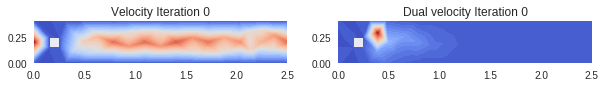

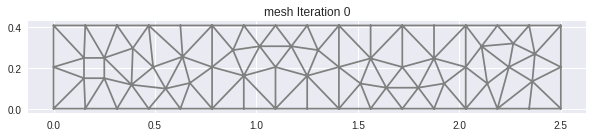

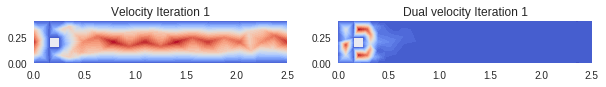

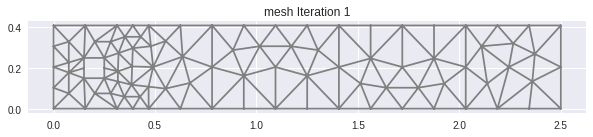

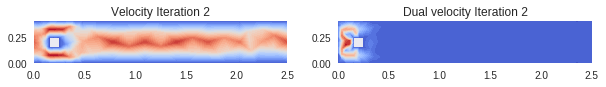

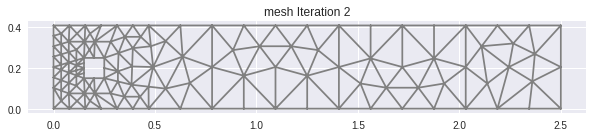

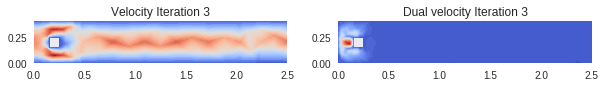

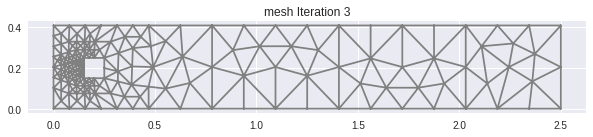

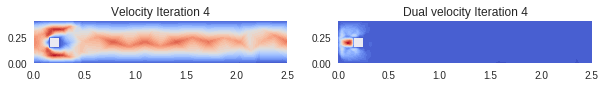

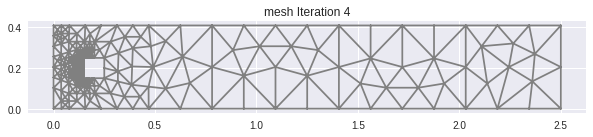

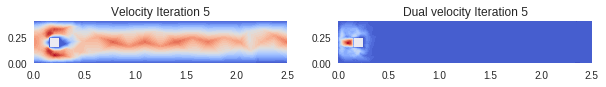

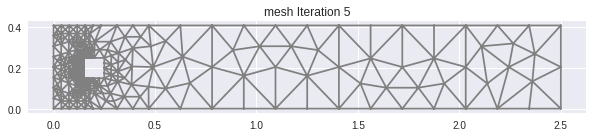

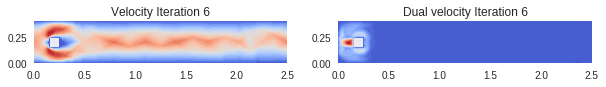

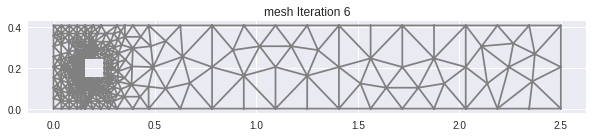

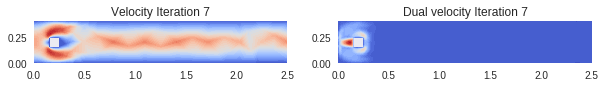

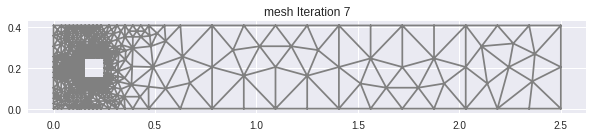

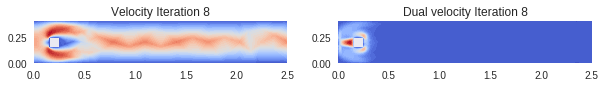

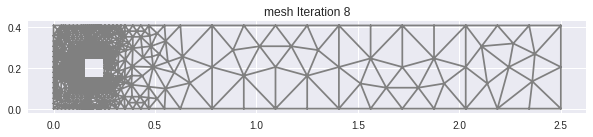

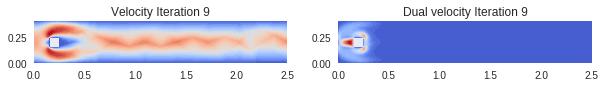

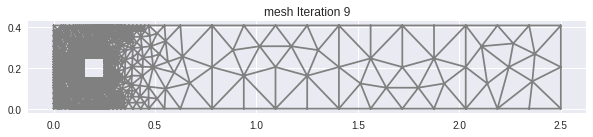

In [65]:
# Copyright (C) 2013 Johan Jansson (jjan@kth.se)

# This file is part of FEniCS
#
# FEniCS is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# Modified by N. Cem Degirmenci 2016 to work on Jupyter-Fenics Environment
# Adapted to Google Colab 2019 Van-Dang Nguyen (vdnguyen@kth.se)

maxiters = 10

Y_MAX = 0.41
X_MAX = 2.5
XMIN=0.;  YMIN=0;  G=[XMIN,X_MAX,YMIN,Y_MAX];

ghole = [0.15, 0.25, 0.15, 0.25];
mesh = generate_mesh(Rectangle(Point(G[0],G[2]),Point(G[1],G[3]))-Rectangle(Point(ghole[0],ghole[2]),Point(ghole[1],ghole[3]) ), 10 )

# SubDomains for defining boundary conditions
class WallBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and( x[1] > Y_MAX - DOLFIN_EPS or \
                                    x[1] < DOLFIN_EPS)

class InnerBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and(x[0] >  DOLFIN_EPS and x[1] >  DOLFIN_EPS and \
                                   x[0] < X_MAX- DOLFIN_EPS and x[1] < Y_MAX- DOLFIN_EPS)

class InflowBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and(x[0] <  DOLFIN_EPS )
   
class OutflowBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and(x[0] > X_MAX -  DOLFIN_EPS )


class PsiMarker(Expression):
    def eval(self, values, x):
        ib = InnerBoundary()

        if(ib.inside(x, True)):
            values[0] = 1.0
        else:
            values[0] = 0.0

psimarker = Expression("x[0] > eps && x[1] > eps && x[0] < X_MAX- eps and x[1] < Y_MAX-eps ? 1. : 0.0", X_MAX=X_MAX, Y_MAX=Y_MAX, eps=DOLFIN_EPS, degree=1)
inflow = Expression(("4*(x[1]*(Y_MAX-x[1]))/(Y_MAX*Y_MAX)", "0."), Y_MAX=Y_MAX, degree=1) # Inflow velocity
            

# Known coefficients
u0_0 = Constant((0.0, 0.0))
f = Constant((0.0, 0.0))
u0_0p = Constant(0.0)

# Use compiler optimizations
parameters["form_compiler"]["cpp_optimize"] = True

# Allow approximating values for points that may be generated outside
# of domain (because of numerical inaccuracies)
parameters["allow_extrapolation"] = True



###### Modify for exercise below ######

# Viscosity
nu = 4e-3

# 
adapt_ratio = 0.1

def M(mesh, u, p):

    def epsilon(z):
        return 0.5*(grad(z) + grad(z).T)

    n = FacetNormal(mesh)

    I = Identity(2)
    sigma = p*I - nu*epsilon(u)
    theta = Constant((1.0, 0.0))

    g = Expression(("200.0*exp(-200.0*(pow(x[0] - 0.5, 2) + pow(x[1] - 0.3, 2)))", "0.0"), degree=2)                              

    M1 = psimarker*p*n[0]*ds # Drag (only pressure)
    M2 = psimarker*p*n[1]*ds # Lift (only pressure)
    M3 = inner(g, u)*dx # Mean of the velocity in a region
    M4 = psimarker*dot(dot(sigma, n), theta)*ds # Drag (full stress)
    M5 = u[0]*dx # Mean of the x-velocity in the whole domain

    return M1

# The strong residual with w the solution (w2 used for simple linerization) 
def R(w, w2):

    (u, p) = (as_vector((w[0], w[1])), w[2])
    (u2, p2) = (as_vector((w2[0], w2[1])), w2[2])

    Au = grad(p) + grad(u2)*u
    Ap = div(u)

    Aui = [Au[i] for i in range(0, 2)]

    return as_vector(Aui + [Ap])

# The weak residual with w the solution and wt the test function
def r(W, w, wt, ei_mode=True, stab=True):

    (u, p) = (as_vector((w[0], w[1])), w[2])
    (v, q) = (as_vector((wt[0], wt[1])), wt[2])

    h = CellDiameter(W.mesh())
    delta = h

    Z = FunctionSpace(W.mesh(), "DG", 0)
    z = TestFunction(Z)

    if(not stab):
        delta = 0.0

    if(not ei_mode):
        z = 1.0

    # Define variational forms
    # Multiply by z to be able to extract error indicators for each cell
    dx = Measure("dx", domain=W.mesh())
    a_G = z*(nu*inner(grad(u), grad(v)) + inner(grad(p) + grad(u)*u, v) + div(u)*q)*dx
    a_stab = z*delta*inner(R(w, w), R(wt, w))*dx
    a = a_G + a_stab
    L = z*inner(f, v)*dx
    F = a - L

    return F

###### Modify for exercise above ######

 

# Solve primal and dual equations and compute error indicators
def adaptive_solve(mesh):
    h = CellDiameter(mesh)
    # Define function spaces
    # Z = FunctionSpace(mesh, "DG", 0)
    # V = VectorFunctionSpace(mesh, "CG", 1)
    # Q = FunctionSpace(mesh, "CG", 1)
    # W = V * Q

    
    VE = VectorElement("CG", mesh.ufl_cell(), 1); QE = FiniteElement("CG", mesh.ufl_cell(), 1); ZE = FiniteElement("DG", mesh.ufl_cell(), 0)
    WE = VE * QE; W = FunctionSpace(mesh, WE); V = FunctionSpace(mesh, VE); Q = FunctionSpace(mesh, QE); Z = FunctionSpace(mesh, ZE); 

    
    # primal solver boundary conditions
    bc_0_0 = DirichletBC(W.sub(0), u0_0, WallBoundary())
    bc_0_1 = DirichletBC(W.sub(0), u0_0, InnerBoundary())
    bc_0_2 = DirichletBC(W.sub(0), inflow, InflowBoundary())
    bc_0_3p = DirichletBC(W.sub(1), u0_0p, OutflowBoundary())

    # Define unknown and test function(s)
    (v, q) = TestFunctions(W)
    wt = TestFunction(W)
    w = Function(W)
    phi = Function(W)
    (u, p) = (as_vector((w[0], w[1])), w[2])

    n = FacetNormal(mesh)

    # The variational form
    F = r(W, w, wt, ei_mode=False, stab=True)

    # Primal boundary conditions
    bcs = [bc_0_0, bc_0_1, bc_0_2, bc_0_3p]

    # Solve the primal problem
    solve(F == 0, w, bcs)

    # Compute output
    output = assemble(M(mesh, u, p))

    # Project output functional
    (ut, pt) = TrialFunctions(W)
    a_psi = inner(ut, v)*dx + inner(pt, q)*dx
    L_psi = M(mesh, v, q)
    psi = Function(W)
    solve(a_psi == L_psi, psi)

    # Generate the dual problem
    a_star = adjoint(derivative(F, w))
    L_star = M(mesh, v, q)

    # Generate dual boundary conditions
    for bc in bcs:
        bc.homogenize()

    # Solve the dual problem
    solve(a_star == L_star, phi, bcs)

    # Generate error indicators
    z = TestFunction(Z)

    (u, p) = w.split()
    (phi_u, phi_p) = phi.split()
    (psi_u, psi_p) = psi.split()

    # Compute error indicators ei
    LR1 = r(W, w, phi, ei_mode=True, stab=False)
    ei = Function(Z)
    # ei.vector()[:] = assemble(LR1).array()
    ei.vector()[:] = assemble(LR1)

    return (u, p, phi_u, phi_p, psi_u, psi_p, output, ei)

# Refine the mesh based on error indicators
def adaptive_refine(mesh, ei, adapt_ratio, adaptive):
    # gamma = abs(ei.vector().array())
    
    gamma = np.abs(ei.vector())

    # Mark cells for refinement
    cell_markers = MeshFunction("bool", mesh, mesh.topology().dim())
    gamma_0 = sorted(gamma, reverse=True)[int(len(gamma)*adapt_ratio) - 1]
    for c in cells(mesh):
        cell_markers[c] = gamma[c.index()] > gamma_0

    # Refine mesh
    if adaptive:
        mesh = refine(mesh, cell_markers)
    else:
        mesh = refine(mesh)

    return mesh

def solve_problem(mesh, adaptive=True):

    results = []

    # Adaptive loop
    t= 0;
    for i in range(0, maxiters):

        # Solve primal and dual equations and compute error indicators
        (u, p, phi_u, phi_p, psi_u, psi_p, output, ei) = adaptive_solve(mesh)

        # Compute error estimate and compare against reference value
        est = abs(sum(ei.vector()))
        ref = 0.14181
        err = abs(ref - output)
        result = (output, est, err, mesh.num_cells())
        results.append(result)
        print("output: %5.5f est: %5.5f err: %5.5f cells: %d" % (output, est, err, mesh.num_cells()))

        QE = FiniteElement("CG", mesh.ufl_cell(), 1); Q = FunctionSpace(mesh, QE);

        # Functionspace used for plotting
        
        plt.figure()
        plt.subplot(1, 2, 1);
        fig = plt.gcf(); fig.set_size_inches(10, 2)
        plot(project(sqrt(inner(u, u)), Q), cmap="coolwarm"); plt.title("Velocity Iteration %d" % i) 
        
          
        plt.subplot(1, 2, 2);
        fig = plt.gcf(); fig.set_size_inches(10, 2)
        plot(project(sqrt(inner(phi_u, phi_u)), Q), cmap="coolwarm"); plt.title("Dual velocity Iteration %d" % i) 


        plt.figure()
        fig = plt.gcf(); fig.set_size_inches(10, 2)
        plot(mesh); plt.title("mesh Iteration %d" % i) 
 
        # Refine the mesh
        mesh = adaptive_refine(mesh, ei, adapt_ratio, adaptive)


# Solve the problem
solve_problem(mesh, adaptive=True)


